<a href="https://colab.research.google.com/github/tololojo/AML_FinalProject/blob/lorenz_dataclass/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade torch
!pip install --upgrade tensorflow
!pip install --upgrade jax
!pip install --upgrade keras-nlp
!pip install --upgrade keras-cv
!pip install --upgrade keras

# Some care is required to install Keras 3. This is a temporary situation.
# See installation notes at the end of this notebook for details.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow import keras
from urllib.request import urlretrieve
from skimage import io
import math
import requests
from PIL import Image
from io import BytesIO
from IPython.core.display import display, HTML

In [3]:
# Set the backend to TensorFlow
backend = 'tensorflow'
os.environ['KERAS_BACKEND'] = backend

import keras
import keras_cv
import keras_nlp

In [4]:
## convert the personal LAB (LAB2)to the RGB
# the input L,a,b,  must be 1D L [0 1], a [-1 1] b [-1 1]
# the outputs are 1D  R g B [0 255]
def LAB22RGB(L, a, b):
    import numpy as np
    a11 = 0.299
    a12 = 0.587
    a13 = 0.114
    a21 = (0.15/0.234)
    a22 = (-0.234/0.234)
    a23 = (0.084/0.234)
    a31 = (0.287/0.785)
    a32 = (0.498/0.785)
    a33 = (-0.785/0.785)

    aa=np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    C0=np.zeros((L.shape[0],3))
    C0[:,0]=L[:,0]
    C0[:,1]=a[:,0]
    C0[:,2]=b[:,0]
    C = np.transpose(C0)
    # C = np.array([L, a, b])
    # print(C.shape)
    # print(L.shape)
    # print(a.shape)
    # print(b.shape)
    # print(aa.shape)

    X = np.linalg.inv(aa).dot(C)
    X1D=np.reshape(X,(X.shape[0]*X.shape[1],1))
    p0=np.where(X1D<0)
    X1D[p0[0]]=0
    p1=np.where(X1D>1)
    X1D[p1[0]]=1
    Xr=np.reshape(X1D,(X.shape[0],X.shape[1]))

    Rr = Xr[0][:]
    Gr = Xr[1][:]
    Br = Xr[2][:]

    R = np.uint(np.round(Rr*255))
    G = np.uint(np.round(Gr*255))
    B = np.uint(np.round(Br*255))
    # p0=np.where(L<0.02)
    # R[p0[0]]=0
    # G[p0[0]]=0
    # B[p0[0]]=0
    # p1=np.where(L>0.98)
    # R[p1[0]]=255
    # G[p1[0]]=255
    # B[p1[0]]=255
    return R, G, B


In [5]:
def from_LAB_to_RGB_img(L, AB):

    # print("*** Transforming LAB img to RGB ***")
    x_dim, y_dim = L.shape[0], L.shape[1]
    predicted_RGB=np.uint8(np.zeros((x_dim,y_dim,3)))
    AB = np.squeeze(AB)
    # print(f"Shape o AB in conversion is {AB.shape}")
    a0, b0 = AB[:, :, 0], AB[:, :, 1]

    # print(f"{np.squeeze(L).shape}, {a0.shape}, {b0.shape}")

    Rr, Gr, Br = LAB22RGB(L.reshape(-1, 1),
                          a0.reshape(-1, 1),
                          b0.reshape(-1, 1))

    predicted_RGB[:, :,0] = np.reshape(Rr,(x_dim,y_dim))
    predicted_RGB[:, :,1] = np.reshape(Gr,(x_dim,y_dim))
    predicted_RGB[:, :,2] = np.reshape(Br,(x_dim,y_dim))


    return predicted_RGB

# Fetch Test Images

Adjusted SwisstopoTileFetcher class from get_imagestiles

In [25]:
class SwisstopoTileFetcher:
    def __init__(self, coordinates, zoom_level, layer_name="ch.swisstopo.swissimage", times=["current"]):
        self.scheme = "https"
        self.server_name = "wmts.geo.admin.ch"  # Can be wmts0 to wmts9
        self.version = "1.0.0"
        self.layer_name = layer_name
        self.style_name = "default"
        self.tile_matrix_set = "3857"  # You might need to adjust this based on the specific requirements
        self.format_extension = "jpeg"
        self.coordinates = coordinates  # List of (longitude, latitude) tuples
        self.zoom_level = zoom_level
        self.times = times  # List of time strings
        self.fetched_tiles = {}  # Initialize an empty dictionary to store fetched tiles

    def lat_lon_to_tile_indices(self, longitude, latitude):
        n = 2 ** self.zoom_level
        lat_rad = math.radians(latitude)
        x_tile = int((longitude + 180.0) / 360.0 * n)
        y_tile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
        return x_tile, y_tile

    def fetch_tile(self, longitude, latitude, time):
        # Convert coordinates to tile indices
        x, y = self.lat_lon_to_tile_indices(longitude, latitude)

        # Construct the URL
        url = f"{self.scheme}://{self.server_name}/{self.version}/{self.layer_name}/{self.style_name}/{time}/{self.tile_matrix_set}/{self.zoom_level}/{x}/{y}.{self.format_extension}"

        # Download the tile
        response = requests.get(url)
        if response.status_code == 200:
            # Open and return the image
            image = Image.open(BytesIO(response.content))
            return image
        else:
            print(f"Failed to download tile. Status code: {response.status_code}")
            return None

    def fetch_all_tiles(self):
        for longitude, latitude in self.coordinates:
            self.fetched_tiles[(longitude, latitude)] = []
            for time in self.times:
                image = self.fetch_tile(longitude, latitude, time)
                if image:
                    self.fetched_tiles[(longitude, latitude)].append((time, image))

    def show_tiles(self):
        self.fetch_all_tiles()
        for (longitude, latitude), image_list in self.fetched_tiles.items():
            fig, axes = plt.subplots(1, len(image_list), figsize=(15, 5))
            fig.suptitle(f"Coordinates: ({longitude}, {latitude})")
            if len(image_list) == 1:
                axes = [axes]  # Ensure axes is iterable if there's only one image
            for ax, (time, image) in zip(axes, image_list):
                ax.imshow(image)
                ax.set_title(f"Time: {time}")
                ax.axis('off')  # Hide the axis
            plt.show()

    def get_tiles(self):
        return self.fetched_tiles

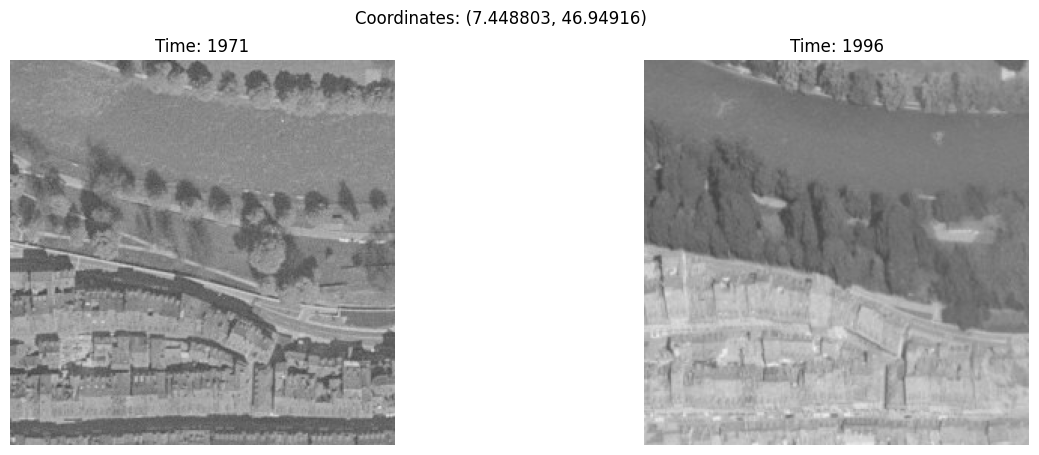

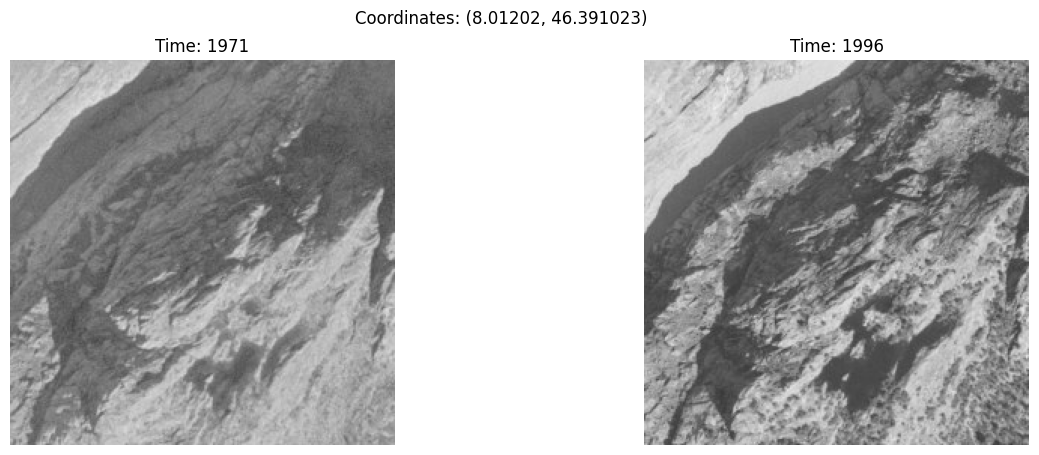

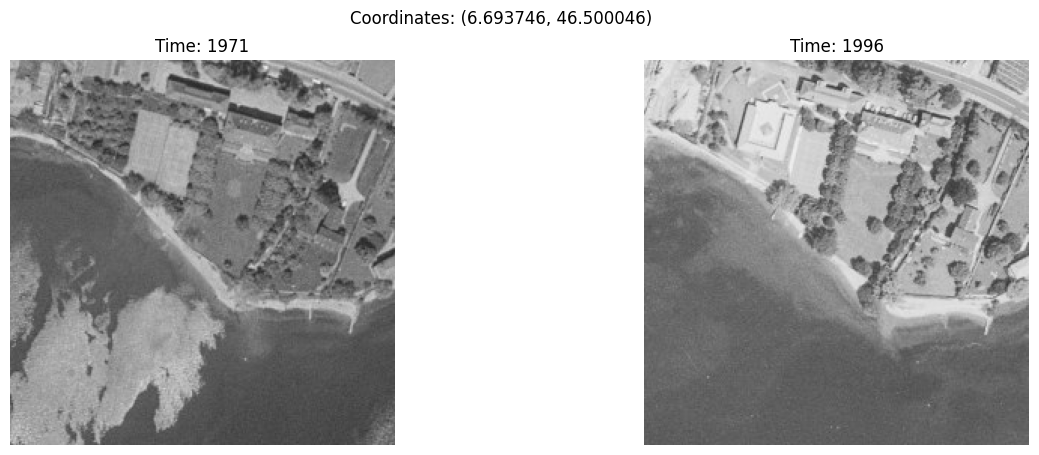

In [30]:
# Fetch images
coordinates = [(7.448803, 46.949160), (8.012020, 46.391023), (6.693746, 46.500046)]
zoom_level = 17
layer_name = "ch.swisstopo.swissimage-product"
times = ["1971", "1996"]

fetched_tiles_swissimage_product = SwisstopoTileFetcher(coordinates, zoom_level, layer_name, times)
fetched_tiles_swissimage_product.show_tiles()


In [32]:
fetched_tiles_swissimage_product.get_tiles()


{(7.448803,
  46.94916): [('1971',
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>), ('1996',
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>)],
 (8.01202,
  46.391023): [('1971',
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>), ('1996',
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>)],
 (6.693746,
  46.500046): [('1971',
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>), ('1996',
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>)]}

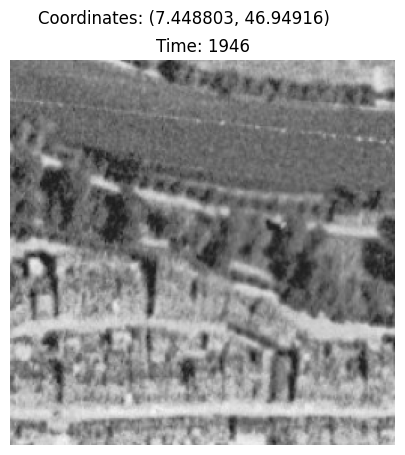

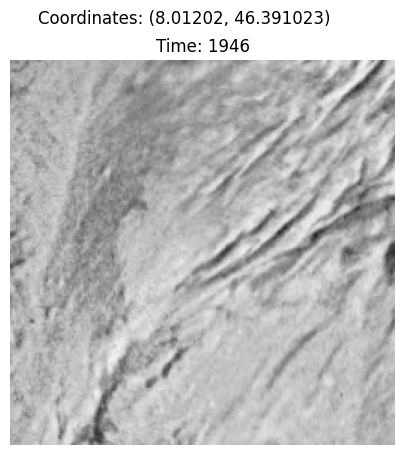

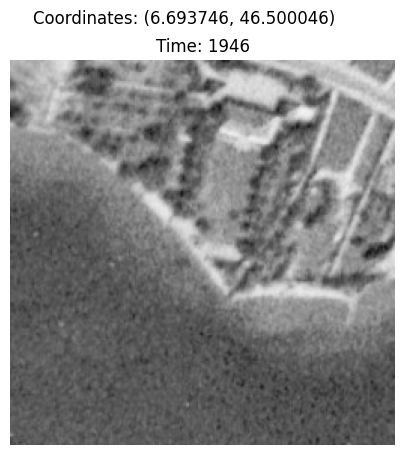

In [31]:
# Fetch images
layer_name = "ch.swisstopo.swissimage-product_1946"
times = ["1946"]

fetched_tiles_swissimage_product_1946 = SwisstopoTileFetcher(coordinates, zoom_level, layer_name, times)
fetched_tiles_swissimage_product_1946.show_tiles()


In [33]:
fetched_tiles_swissimage_product_1946.get_tiles()

{(7.448803,
  46.94916): [('1946',
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>)],
 (8.01202,
  46.391023): [('1946',
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>)],
 (6.693746,
  46.500046): [('1946',
   <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>)]}

In [34]:
# Initialize combined_tiles as an empty dictionary
combined_tiles = {}

# Iterate over both fetchers and update combined_tiles
for fetcher in [fetched_tiles_swissimage_product, fetched_tiles_swissimage_product_1946]:
    for coord, tile_list in fetcher.get_tiles().items():
        combined_tiles.setdefault(coord, []).extend(tile_list)

# Print or use combined_tiles as needed
print(combined_tiles)

{(7.448803, 46.94916): [('1971', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F421523D270>), ('1996', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F42152142E0>), ('1946', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F42154CD900>)], (8.01202, 46.391023): [('1971', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F421526F790>), ('1996', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F4215217550>), ('1946', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F42154CDE10>)], (6.693746, 46.500046): [('1971', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F421523D120>), ('1996', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F421523DFF0>), ('1946', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F421537BCD0>)]}


# Load Models

Baseline model

In [11]:
url = ("https://drive.usercontent.google.com/download?id=19DaA9f1HIOW9PmUz11xKw65fCo3X7-Fw&export=download&authuser=0&confirm=t&uuid=8a03b6f8-6f5d-4bc8-a62d-8b0cfc98d2db&at=APZUnTU9WqjmYlQcAGh22O2M8wXI%3A1717452655512")
filename="Hyper_U_Net.h5"

if not os.path.exists(os.path.join(os.curdir, "Hyper_U_Net.h5")):
    path, headers = urlretrieve(url, filename)
# for name, value in headers.items():
#     print(name, value)
model1 = keras.models.load_model(os.path.join(os.curdir, "Hyper_U_Net.h5"))

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Retrained Hyper U Net 30 Epochs

In [12]:
!wget -O Retrained_Hyper_U_Net_e30.h5 "https://perritos.myasustor.com:1986/Models/HyperUnet_retrained_30e/Retrained_Hyper_U_Net.h5"

--2024-07-01 07:30:02--  https://perritos.myasustor.com:1986/Models/HyperUnet_retrained_30e/Retrained_Hyper_U_Net.h5
Resolving perritos.myasustor.com (perritos.myasustor.com)... 31.165.170.194
Connecting to perritos.myasustor.com (perritos.myasustor.com)|31.165.170.194|:1986... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381849356 (364M)
Saving to: ‘Retrained_Hyper_U_Net_e30.h5’

Retrained_Hyper_U_N 100%[===================>] 364.16M  2.75MB/s    in 4m 32s  

2024-07-01 07:34:35 (1.34 MB/s) - ‘Retrained_Hyper_U_Net_e30.h5’ saved [381849356/381849356]



In [13]:
model_filename = "Retrained_Hyper_U_Net_e30.h5"
model2 = load_model(model_filename)


Augmented Model

In [14]:
!wget -O HyperUnet_retrain_augmented_noise_ckpt_epoch08_valloss0.0010.keras "https://perritos.myasustor.com:1986/Models/HyperUnet_retrain_augmented_noise/HyperUnet_retrain_augmented_noise_ckpt_epoch08_valloss0.0010.keras"

--2024-07-01 07:36:03--  https://perritos.myasustor.com:1986/Models/HyperUnet_retrain_augmented_noise/HyperUnet_retrain_augmented_noise_ckpt_epoch08_valloss0.0010.keras
Resolving perritos.myasustor.com (perritos.myasustor.com)... 31.165.170.194
Connecting to perritos.myasustor.com (perritos.myasustor.com)|31.165.170.194|:1986... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381889022 (364M)
Saving to: ‘HyperUnet_retrain_augmented_noise_ckpt_epoch08_valloss0.0010.keras’

HyperUnet_retrain_a 100%[===================>] 364.20M  1015KB/s    in 4m 19s  

2024-07-01 07:40:23 (1.41 MB/s) - ‘HyperUnet_retrain_augmented_noise_ckpt_epoch08_valloss0.0010.keras’ saved [381889022/381889022]



In [15]:
model_filename = "HyperUnet_retrain_augmented_noise_ckpt_epoch08_valloss0.0010.keras"
model3 = load_model(model_filename)


Combine and name the models

In [16]:
models = {"Baseline Model": model1, "HyperUNet Retrained": model2, "HyperUNet Augmented": model3}


In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
output_dir = '/content/drive/MyDrive/CAS Advanced Machine Learning/Luftbild_Colorization/Colorized_Images'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

In [40]:
class ImageColorizer:
    def __init__(self, models, output_dir):
        self.models = models  # Dictionary of models: {model_name: model}
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def LAB22RGB(self, L, a, b):
        a11 = 0.299
        a12 = 0.587
        a13 = 0.114
        a21 = (0.15/0.234)
        a22 = (-0.234/0.234)
        a23 = (0.084/0.234)
        a31 = (0.287/0.785)
        a32 = (0.498/0.785)
        a33 = (-0.785/0.785)

        aa = np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
        C0 = np.zeros((L.shape[0], 3))
        C0[:, 0] = L[:, 0]
        C0[:, 1] = a[:, 0]
        C0[:, 2] = b[:, 0]
        C = np.transpose(C0)

        X = np.linalg.inv(aa).dot(C)
        X1D = np.reshape(X, (X.shape[0] * X.shape[1], 1))
        X1D = np.clip(X1D, 0, 1)
        Xr = np.reshape(X1D, (X.shape[0], X.shape[1]))

        Rr = Xr[0][:]
        Gr = Xr[1][:]
        Br = Xr[2][:]

        R = np.uint8(np.round(Rr * 255))
        G = np.uint8(np.round(Gr * 255))
        B = np.uint8(np.round(Br * 255))

        return R, G, B

    def colorize_tiles(self, combined_tiles, plot=False):
        # Iterate through combined_tiles
        for coord, tile_list in combined_tiles.items():
            for time, image in tile_list:
                # Convert PIL image to numpy array
                img_np = np.array(image)

                # Normalize the L channel
                L = img_np[:, :, 0] / 255.0
                L = np.expand_dims(L, axis=-1)
                L = np.expand_dims(L, axis=0)

                # Plot the original image if required
                if plot:
                    plt.figure(figsize=(15, 10))
                    plt.subplot(1, len(self.models) + 1, 1)
                    plt.title('Original Black & White Image')
                    plt.imshow(img_np, cmap='gray')
                    plt.axis('off')

                # Colorize the image using each model
                for i, (model_name, model) in enumerate(self.models.items(), start=2):
                    # Predict the color channels
                    predicted = model.predict(L, verbose=0)
                    predicted = np.reshape(predicted, (img_np.shape[0] * img_np.shape[1], 2))
                    a = predicted[:, 0:1]
                    b = predicted[:, 1:2]

                    L_flat = np.reshape(L, (img_np.shape[0] * img_np.shape[1], 1))

                    # Convert LAB to RGB
                    R, G, B = self.LAB22RGB(L_flat, a, b)
                    R = np.reshape(R, (img_np.shape[0], img_np.shape[1]))
                    G = np.reshape(G, (img_np.shape[0], img_np.shape[1]))
                    B = np.reshape(B, (img_np.shape[0], img_np.shape[1]))
                    colorized_img = np.stack((R, G, B), axis=-1)

                    # Save the colorized image with a meaningful name
                    output_path = os.path.join(self.output_dir, f"{coord[0]}_{coord[1]}_{time}_{model_name}.tif")
                    io.imsave(output_path, colorized_img)

                    if plot:
                        # Plot the colorized image
                        plt.subplot(1, len(self.models) + 1, i)
                        plt.title(f'Colorized with {model_name} - Time: {time}')
                        plt.imshow(colorized_img)
                        plt.axis('off')

                if plot:
                    plt.show()

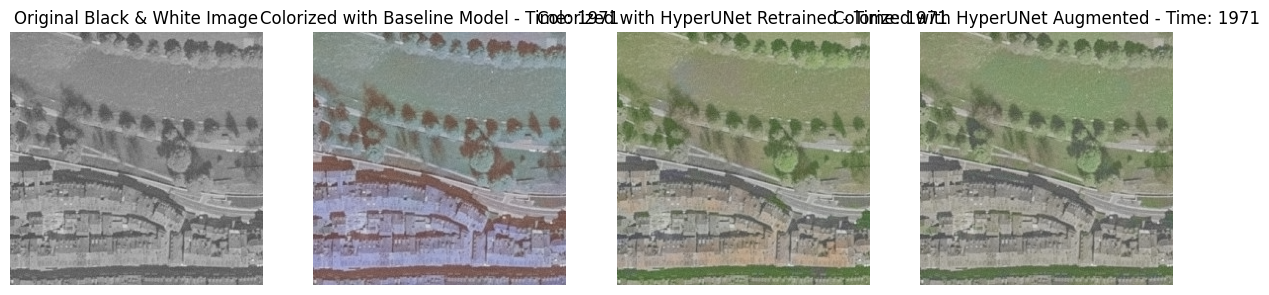

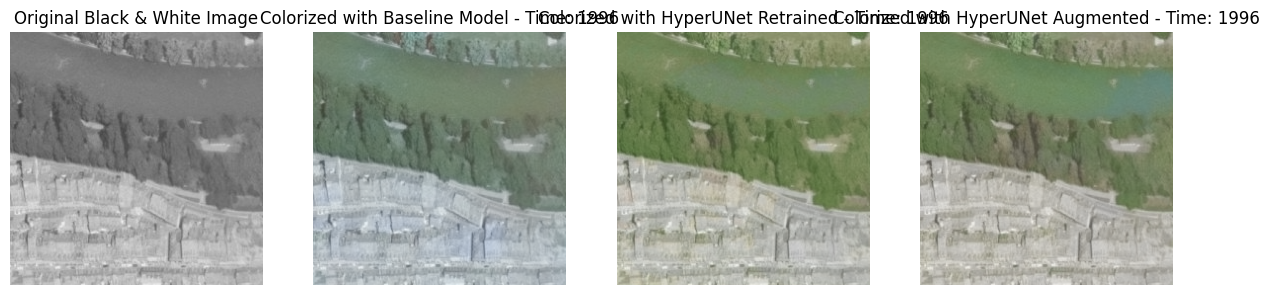

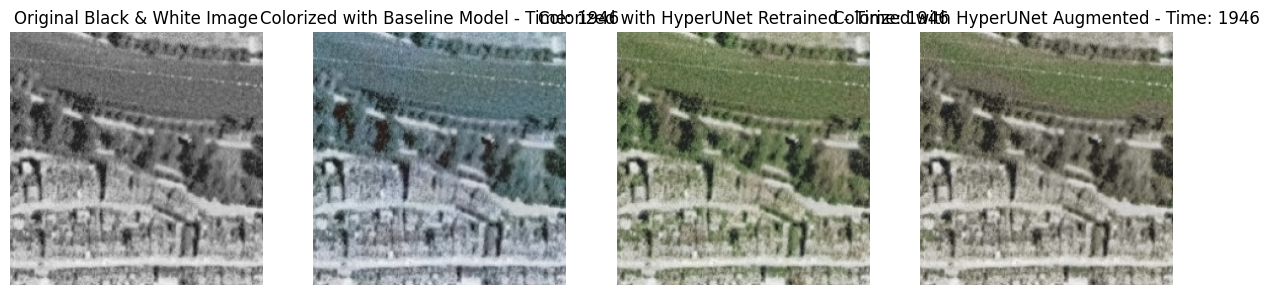

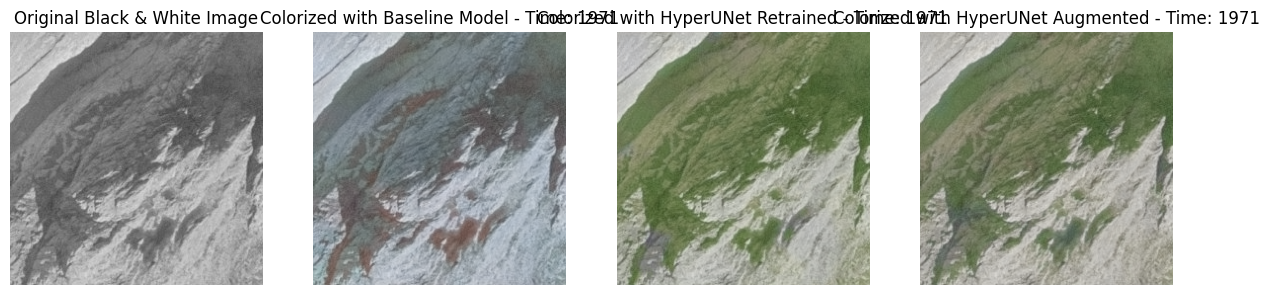

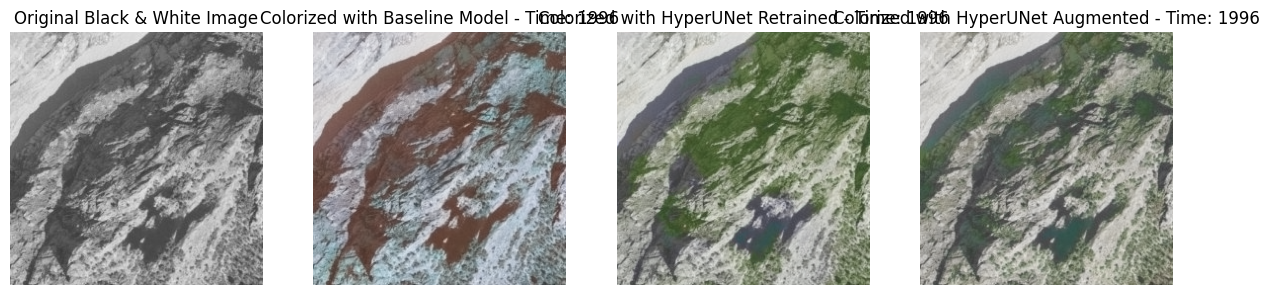

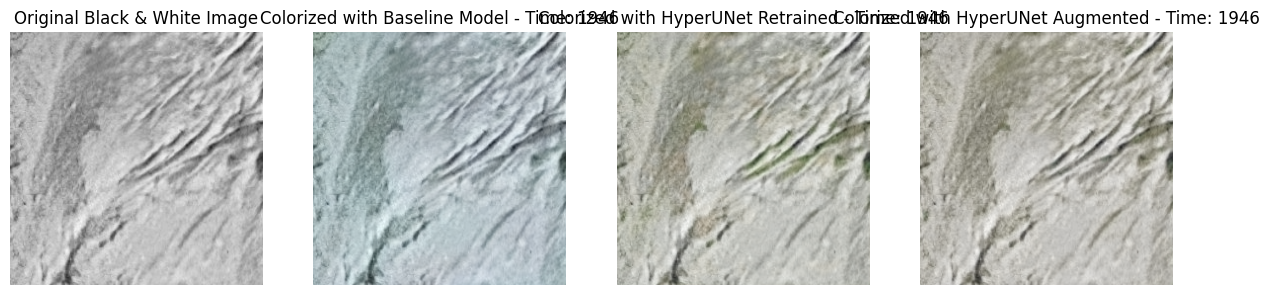

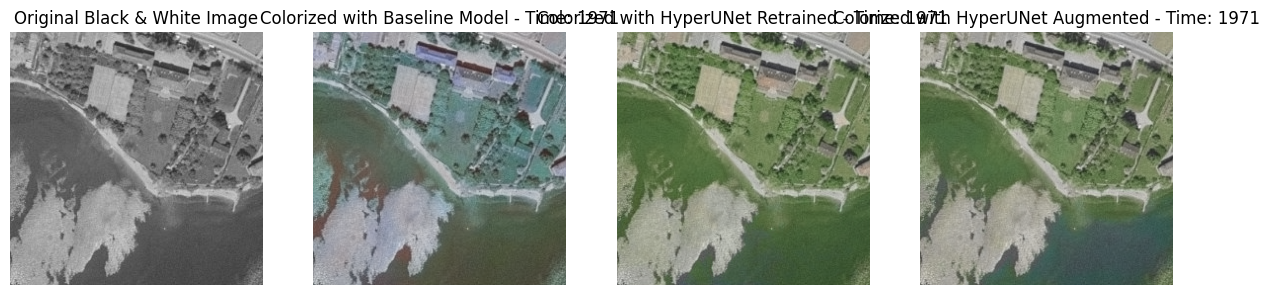

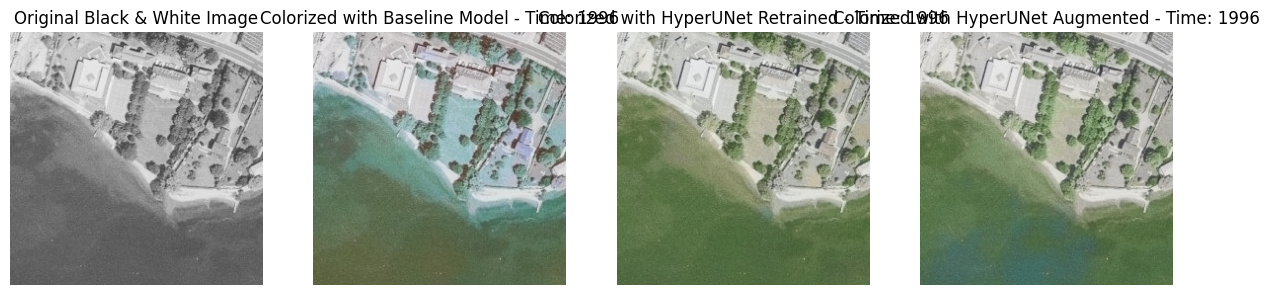

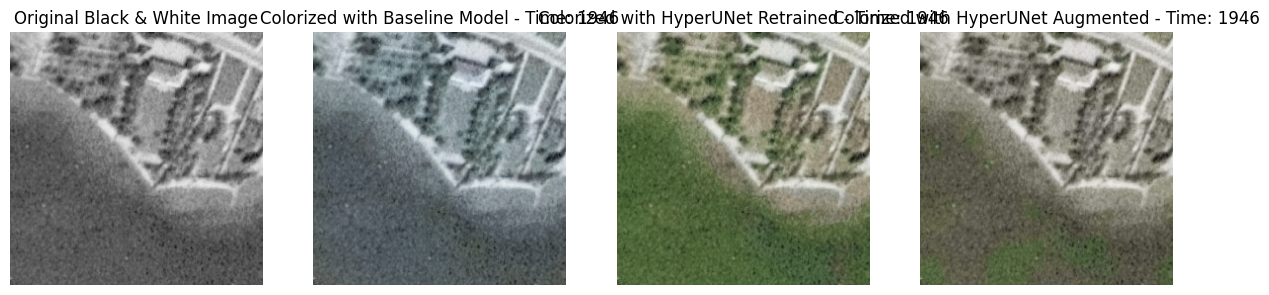

In [41]:
colorizer = ImageColorizer(models, output_dir)
colorizer.colorize_tiles(combined_tiles, plot=True)